In [10]:
!pip install numpy matplotlib scipy sympy


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Перевод уравнения 
$$
\ddot{y}(t) + 5\dot{y}(t)+2y(t) = 5\dot{u}(t) + u(t).
$$
в систему ДУ 1-го порядка с дополнительными обозначениями:
$$
x_1(t) = y(t),\quad x_2(t) = \dot{y}(t) \Longrightarrow \dot{x_2}(t)=\ddot{y}(t).
$$ 

In [11]:
import sympy as sp

# Define symbols and functions
t = sp.symbols('t')
y = sp.Function('y')
u = sp.Function('u')

# Given second-order ODE
ode = sp.Eq(y(t).diff(t, 2) + 5*y(t).diff(t) + 2*y(t), 5*u(t).diff(t) + u(t))

# Define state functions
x1 = sp.Function('x1')(t)
x2 = sp.Function('x2')(t)

# Constraints: x1 = y, x2 = dy/dt
eq1 = sp.Eq(x1 - y(t), 0)
eq2 = sp.Eq(x2 - y(t).diff(t), 0)

# Differentiate constraints
eq1d = sp.Eq(sp.diff(x1, t) - sp.diff(y(t), t), 0)
eq2d = sp.Eq(sp.diff(x2, t) - sp.diff(y(t), t, 2), 0)

# Solve for y'' from the original ODE
y2_expr = sp.solve(ode, y(t).diff(t, 2))[0]

# Build the state equations automatically
eq1_ss = eq1d.subs({sp.diff(y(t), t): x2})
eq2_ss = sp.Eq(sp.diff(x2, t), y2_expr.subs({y(t): x1, sp.diff(y(t), t): x2}))

# Print the resulting system
print("State equations:")
print(eq1_ss)
print(eq2_ss)
print("Output equation: y = x1")


State equations:
Eq(-x2(t) + Derivative(x1(t), t), 0)
Eq(Derivative(x2(t), t), u(t) - 2*x1(t) - 5*x2(t) + 5*Derivative(u(t), t))
Output equation: y = x1


Получившаяся система должна соответствовать этой:
$$
\left\{\begin{matrix}
    \dot{x_1} = x_2, \\
    \dot{x_2} = - 5 x_2 - 2 x_1 + 5\dot{u} + u,\\
    y = x_1.
\end{matrix}\right.
$$

Введём дополнительные обозначения: 
$$
x_3(t) = u(t);\quad \dot{x_3}(t) = v(t).
$$
Проведём конвертацию так, чтобы в получившейся системе уравнений не содержалась производная $\dot{u}$.

In [12]:
import sympy as sp

# Symbols and functions
t = sp.symbols('t')
y = sp.Function('y')(t)
u = sp.Function('u')(t)

# Given second-order ODE
ode = sp.Eq(y.diff(t, 2) + 5*y.diff(t) + 2*y, 5*u.diff(t) + u)

# Define state variables
x1 = sp.Function('x1')(t)
x2 = sp.Function('x2')(t)
x3 = sp.Function('x3')(t)

# Constraints: x1 = y, x2 = y', x3 = u
constraints = [
    sp.Eq(x1, y),
    sp.Eq(x2, y.diff(t)),
    sp.Eq(x3, u)
]

# Differentiate constraints w.r.t. t
d_constraints = [
    sp.Eq(sp.diff(c.lhs, t), sp.diff(c.rhs, t))
    for c in constraints
]

# Solve ODE for y''
y_dd = sp.solve(ode, y.diff(t, 2))[0]

# Build the state equations
eq1_ss = d_constraints[0].subs({y.diff(t): x2})
eq2_ss = sp.Eq(
    x2.diff(t),
    y_dd.subs({y: x1, y.diff(t): x2})
)
eq3_ss = d_constraints[2]  # dot x3 = dot u

# Display results
print("State equations:")
print(eq1_ss)   # ˙x1 = x2
print(eq2_ss)   # ˙x2 = -2*x1 - 5*x2 + u + 5*u'
print(eq3_ss)   # ˙x3 = u'

print("\nOutput equation: y = x1")


State equations:
Eq(Derivative(x1(t), t), x2(t))
Eq(Derivative(x2(t), t), u(t) - 2*x1(t) - 5*x2(t) + 5*Derivative(u(t), t))
Eq(Derivative(x3(t), t), Derivative(u(t), t))

Output equation: y = x1


Мы получаем примерно такой же вывод, но можно заменить $u = x_3$, $\dot{u} = v$:
$$\left\{\begin{matrix}
    \dot{x_1} = x_2, \\
    \dot{x_2} = - 2 x_1 - 5 x_2 + x_3 + 5 v, \\
    \dot{x_3} = v, \\
    y = x_1.
\end{matrix}\right.$$

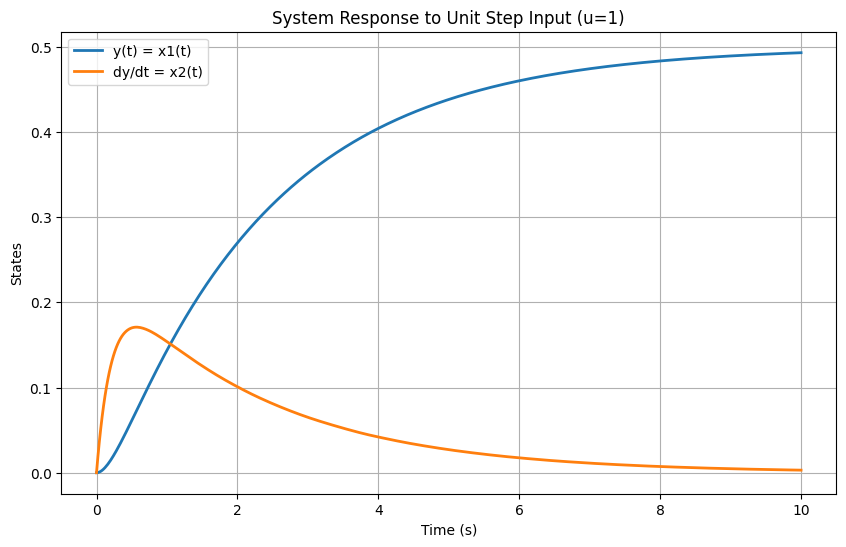

In [13]:
# Re-running after reset
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# System definition with explicit parameters
def system(t, x):
    # Unit step input u(t)=1, thus u'(t)=0
    u = 1
    u_dot = 0
    x1, x2 = x
    dx1dt = x2
    dx2dt = -2*x1 - 5*x2 + u + 5*u_dot
    return [dx1dt, dx2dt]

# Initial conditions
x0 = [0, 0]

# Time range
t_span = (0, 10)
t_eval = np.linspace(*t_span, 500)

# Solve the ODE system numerically
solution = solve_ivp(system, t_span, x0, t_eval=t_eval)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(solution.t, solution.y[0], label='y(t) = x1(t)', linewidth=2)
plt.plot(solution.t, solution.y[1], label="dy/dt = x2(t)", linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('States')
plt.title('System Response to Unit Step Input (u=1)')
plt.grid(True)
plt.legend()
plt.show()
